# Evaluate Semantic SASRec Model

In [1]:
import shutil
import sys
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from tqdm.auto import tqdm

import wandb

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

from src.device_manager import DeviceManager
from src.logger import setup_logger

# Import model classes and tokenization function from training script
from src.train_sasrec_semantic_id import SemanticSASRec, SemanticSASRecConfig, encode_semantic_id

# Setup
logger = setup_logger("evaluate-semantic-sasrec", log_to_file=False)
device_manager = DeviceManager(logger)
device = device_manager.device

20:24:27 - Using device: mps


## Configuration

In [2]:
@dataclass
class EvalConfig:
    """Configuration for semantic SASRec evaluation."""

    # Data
    dataset: str = "Video_Games"
    data_dir: Path = field(default_factory=lambda: Path("../data"))
    sequences_path: Path = field(
        default_factory=lambda: Path("../data/output/Video_Games_sequences_with_semantic_ids_val.parquet")
    )

    # Model
    models_dir: Path = field(default_factory=lambda: Path("../models/semantic_sasrec"))
    artifact_path: str = "eugeneyan/sasrec-experiments/semantic-sasrec-final-Video_Games:v0"

    # Semantic ID settings (must match training)
    num_levels: int = 4  # Number of hierarchical levels
    codebook_size: int = 256  # Size of codebook per level

    # Evaluation
    val_fraction: float = 1  # Fraction of data to use for validation
    batch_size: int = 256
    num_negative_samples: int = 1000  # Number of negative samples for evaluation
    max_seq_length: int = 50
    seed: int = 42

    def __post_init__(self):
        """Create directories if needed."""
        self.models_dir.mkdir(parents=True, exist_ok=True)


config = EvalConfig()
logger.info(f"Configuration: {config}")

20:24:27 - Configuration: EvalConfig(dataset='Video_Games', data_dir=PosixPath('../data'), sequences_path=PosixPath('../data/output/Video_Games_sequences_with_semantic_ids_val.parquet'), models_dir=PosixPath('../models/semantic_sasrec'), artifact_path='eugeneyan/sasrec-experiments/semantic-sasrec-final-Video_Games:v0', num_levels=4, codebook_size=256, val_fraction=1, batch_size=256, num_negative_samples=1000, max_seq_length=50, seed=42)


## Download Model from W&B

In [3]:
# Download model from W&B
logger.info(f"Downloading model from W&B: {config.artifact_path}")

version = config.artifact_path.split(":")[-1]
run = wandb.init(project="semantic-sasrec-evaluation", name=f"eval-semantic-sasrec-{version}")
artifact = run.use_artifact(config.artifact_path, type="model")
artifact_dir = artifact.download(config.models_dir)

# Find and rename the downloaded model file
downloaded_files = list(Path(artifact_dir).glob("*.pth"))
if downloaded_files:
    old_path = downloaded_files[0]
    new_path = config.models_dir / f"semantic_sasrec_{config.dataset.lower()}_{version}.pth"
    if old_path != new_path:
        shutil.move(str(old_path), str(new_path))
    model_path = new_path
    logger.info(f"Model downloaded to {model_path}")
else:
    raise FileNotFoundError(f"No .pth file found in {artifact_dir}")

wandb.finish()

20:24:27 - Downloading model from W&B: eugeneyan/sasrec-experiments/semantic-sasrec-final-Video_Games:v0


wandb: Currently logged in as: eugeneyan to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


20:24:31 - Model downloaded to ../models/semantic_sasrec/semantic_sasrec_video_games_v0.pth


## Load Model from Checkpoint

In [4]:
def load_semantic_sasrec_model(model_path: str, device: str = None) -> Tuple[SemanticSASRec, SemanticSASRecConfig, str]:
    """Load Semantic SASRec model from checkpoint."""

    # Auto-detect device if not specified
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

    # Load checkpoint
    logger.info(f"Loading checkpoint from {model_path}")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Extract config from checkpoint
    if "config" in checkpoint:
        config_dict = checkpoint["config"]
        logger.info("Found config in checkpoint")

        # Create SemanticSASRecConfig from saved config
        semantic_config = SemanticSASRecConfig()

        # Update config parameters if they exist in the saved config
        if isinstance(config_dict, dict):
            for key, value in config_dict.items():
                if hasattr(semantic_config, key):
                    setattr(semantic_config, key, value)
                    if key in ["num_levels", "codebook_size", "hidden_dim", "num_blocks", "num_heads"]:
                        logger.info(f"  {key}: {value}")
    else:
        # Use default config
        logger.warning("No config found in checkpoint, using defaults")
        semantic_config = SemanticSASRecConfig()

    # Get state dict
    state_dict = checkpoint["model_state_dict"]

    # Handle compiled model state dict (keys might start with '_orig_mod.')
    if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
        logger.info("Detected compiled model, removing '_orig_mod.' prefix")
        state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}

    # Create model instance
    model = SemanticSASRec(semantic_config)

    # Load weights
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    # Log model info
    total_params = sum(p.numel() for p in model.parameters())
    logger.info(f"Model loaded successfully on {device}")
    logger.info(f"Total parameters: {total_params:,}")

    return model, semantic_config, device


# Load the model
model, semantic_config, device = load_semantic_sasrec_model(str(model_path), device=device)
logger.info(f"Model config: {semantic_config}")

20:24:31 - Loading checkpoint from ../models/semantic_sasrec/semantic_sasrec_video_games_v0.pth
20:24:31 - Found config in checkpoint
20:24:31 -   num_levels: 4
20:24:31 -   codebook_size: 256
20:24:31 -   num_heads: 6
20:24:31 -   hidden_dim: 384
20:24:31 -   num_blocks: 4
20:24:31 - Detected compiled model, removing '_orig_mod.' prefix
20:24:32 - Model loaded successfully on mps
20:24:32 - Total parameters: 7,035,904
20:24:32 - Model config: SemanticSASRecConfig(dataset='Video_Games', data_dir=PosixPath('data'), data_path=PosixPath('data/output/Video_Games_sequences_with_semantic_ids_train.parquet'), checkpoint_dir=PosixPath('checkpoints/sasrec'), num_levels=4, codebook_size=256, vocab_size=1024, max_seq_length=100, input_dim=128, head_dim=64, num_heads=6, hidden_dim=384, num_blocks=4, mlp_dim=1024, dropout_rate=0.1, batch_size=1024, gradient_accumulation_steps=1, num_epochs=200, max_learning_rate=0.001, min_learning_rate=1e-05, weight_decay=0.0, l2_emb=0.0, teacher_forcing_ratio=0.9

## Load and Prepare Data

In [5]:
# Load sequences data
logger.info(f"Loading data from {config.sequences_path}")
df = pl.read_parquet(config.sequences_path)
logger.info(f"Loaded {len(df)} sequences")
logger.info(f"Columns: {df.columns}")

# Extract sequences - using semantic_id_sequence this time
users = df["user_id"].to_list()
semantic_sequences = df["semantic_id_sequence"].to_list()  # Use these for evaluation

# Filter sequences with at least 2 items (need one for input, one for target)
# AND truncate to max_seq_length if needed
valid_data = []
truncated_count = 0
for u, s_seq in zip(users, semantic_sequences):
    if len(s_seq) >= 2:
        if len(s_seq) > config.max_seq_length:
            # Keep the most recent max_seq_length items (not tokens!)
            s_seq = s_seq[-config.max_seq_length :]
            truncated_count += 1
        valid_data.append((u, s_seq))

logger.info(f"Valid sequences (>= 2 items): {len(valid_data)}")
logger.info(f"Sequences truncated to max_seq_length ({config.max_seq_length} items): {truncated_count}")

# Sample validation set
np.random.seed(config.seed)
n_val = int(len(valid_data) * config.val_fraction)
val_indices = np.random.choice(len(valid_data), size=n_val, replace=False)
val_data = [valid_data[i] for i in val_indices]
logger.info(f"Sampled {len(val_data)} sequences for validation")

# Log sequence length statistics after truncation
seq_lengths = [len(s_seq) for _, s_seq in val_data]
logger.info(
    f"Sequence length stats after truncation (in items): min={min(seq_lengths)}, max={max(seq_lengths)}, avg={np.mean(seq_lengths):.1f}"
)
logger.info(f"Max token sequence length will be: {max(seq_lengths) * config.num_levels} tokens")

20:24:32 - Loading data from ../data/output/Video_Games_sequences_with_semantic_ids_val.parquet
20:24:32 - Loaded 7862 sequences
20:24:32 - Columns: ['user_id', 'sequence', 'sequence_length', 'semantic_id_sequence', 'semantic_id_sequence_length']
20:24:32 - Valid sequences (>= 2 items): 7862
20:24:32 - Sequences truncated to max_seq_length (50 items): 16
20:24:32 - Sampled 7862 sequences for validation
20:24:32 - Sequence length stats after truncation (in items): min=3, max=50, avg=6.5
20:24:32 - Max token sequence length will be: 200 tokens


## Tokenize Semantic IDs and Build Candidate Pool

In [6]:
# Tokenize all semantic IDs and build candidate pool
logger.info("Tokenizing semantic IDs and building candidate pool...")

# Collect all unique semantic IDs and their tokenizations
unique_semantic_ids = set()
for _, semantic_seq in val_data:
    unique_semantic_ids.update(semantic_seq)

# Create mapping from semantic ID to tokens
sid_to_tokens = {}
for sid in unique_semantic_ids:
    tokens = encode_semantic_id(sid, config.num_levels, config.codebook_size)
    sid_to_tokens[sid] = tokens

# Create candidate pool (list of token sequences)
candidate_pool = list(sid_to_tokens.values())
num_unique_items = len(candidate_pool)

logger.info(f"Unique semantic IDs: {num_unique_items}")
logger.info(f"Vocabulary size: {semantic_config.vocab_size}")
logger.info(f"Max token value in pool: {max(max(tokens) for tokens in candidate_pool)}")

# Create reverse mapping for efficient lookups
tokens_to_index = {tuple(tokens): idx for idx, tokens in enumerate(candidate_pool)}

20:24:32 - Tokenizing semantic IDs and building candidate pool...
20:24:32 - Unique semantic IDs: 10396
20:24:32 - Vocabulary size: 1024
20:24:32 - Max token value in pool: 802


## Prepare Validation Data with Token Sequences

In [7]:
# Convert validation data to token sequences
val_data_tokens = []

for user, semantic_seq in val_data:
    # Tokenize the entire sequence
    full_token_seq = []
    for sid in semantic_seq:
        tokens = sid_to_tokens[sid]
        full_token_seq.extend(tokens)  # Flatten: each item becomes 4 tokens

    val_data_tokens.append((user, full_token_seq, len(semantic_seq)))

logger.info(f"Converted {len(val_data_tokens)} sequences to token format")

# Show example
if val_data_tokens:
    user, token_seq, seq_len = val_data_tokens[0]
    logger.info(f"Example: User {user}, Sequence length: {seq_len} items, Token length: {len(token_seq)} tokens")
    logger.info(f"First item tokens: {token_seq[:4]}")

20:24:32 - Converted 7862 sequences to token format
20:24:32 - Example: User AGMBI6FALBGSJKGHFJLJFOULMY5Q, Sequence length: 12 items, Token length: 48 tokens
20:24:32 - First item tokens: [155, 348, 679, 768]


## Evaluation Functions

In [8]:
def calculate_metrics(ranks: np.ndarray, k: int = 10) -> Dict[str, float]:
    """Calculate Hit@k and NDCG@k from ranks."""
    hit_at_k = np.mean(ranks <= k)

    # NDCG@k
    ndcg_at_k = 0.0
    for rank in ranks:
        if rank <= k:
            ndcg_at_k += 1 / np.log2(rank + 1)
    ndcg_at_k /= len(ranks)

    return {f"hit@{k}": hit_at_k, f"ndcg@{k}": ndcg_at_k}


def get_user_seen_tokens(user_token_seq: List[int], num_levels: int) -> set:
    """Get set of seen item token tuples for a user."""
    seen_items = set()
    for i in range(0, len(user_token_seq), num_levels):
        item_tokens = tuple(user_token_seq[i : i + num_levels])
        seen_items.add(item_tokens)
    return seen_items


def evaluate_semantic_model(
    model: SemanticSASRec,
    val_data_tokens: List[Tuple[str, List[int], int]],
    candidate_pool: List[List[int]],
    batch_size: int = 256,
    num_neg_samples: int = 100,
    device: str = "cpu",
    semantic_config: SemanticSASRecConfig = None,
) -> Tuple[Dict[str, float], np.ndarray]:
    """
    Evaluate Semantic SASRec model on validation data.

    Args:
        model: Trained SemanticSASRec model
        val_data_tokens: List of (user, token_sequence, original_seq_length) tuples
        candidate_pool: List of all unique item token sequences
        batch_size: Batch size for evaluation
        num_neg_samples: Number of negative samples
        device: Device to run on
        semantic_config: Model configuration

    Returns:
        Tuple of (metrics dict, ranks array)
    """
    model.eval()

    logger.info(f"Evaluating with {num_neg_samples} negative samples from pool of {len(candidate_pool)} items")

    all_ranks = []
    num_levels = semantic_config.num_levels
    max_token_length = semantic_config.max_seq_length * num_levels

    with torch.no_grad():
        for batch_start in tqdm(range(0, len(val_data_tokens), batch_size), desc="Evaluating"):
            batch = val_data_tokens[batch_start : batch_start + batch_size]

            batch_input_tokens = []
            batch_targets = []
            batch_candidates = []

            for user, token_seq, original_seq_len in batch:
                # Use all but last item as input
                split_idx = (original_seq_len - 1) * num_levels
                input_tokens = token_seq[:split_idx]
                target_tokens = token_seq[split_idx : split_idx + num_levels]

                # Truncate if longer than max_token_length
                if len(input_tokens) > max_token_length:
                    input_tokens = input_tokens[-max_token_length:]

                batch_input_tokens.append(input_tokens)
                batch_targets.append(target_tokens)

                # Sample items from entire catalog, excluding the target
                target_tuple = tuple(target_tokens)
                valid_indices = [
                    idx for idx, item_tokens in enumerate(candidate_pool) if tuple(item_tokens) != target_tuple
                ]

                sampled_indices = np.random.choice(
                    valid_indices, size=min(num_neg_samples, len(valid_indices)), replace=False
                )

                # Create candidate list: target at position 0, then negatives
                candidates = [target_tokens] + [candidate_pool[idx] for idx in sampled_indices]
                batch_candidates.append(candidates)

            # Prepare input tensor
            max_len = max(len(s) for s in batch_input_tokens)
            input_tensor = torch.zeros((len(batch), max_len), dtype=torch.long, device=device)

            for i, tokens in enumerate(batch_input_tokens):
                input_tensor[i, -len(tokens) :] = torch.tensor(tokens, dtype=torch.long)

            # Prepare candidates tensor [batch_size, num_candidates, num_levels]
            candidates_tensor = torch.tensor(batch_candidates, dtype=torch.long, device=device)

            # Get predictions using score_candidates method
            scores = model.score_candidates(input_tensor, candidates_tensor)

            # Find rank of target item (which is at position 0)
            for i in range(len(batch)):
                user_scores = scores[i]
                rank = (user_scores[0] < user_scores).sum().item() + 1
                all_ranks.append(rank)

    # Calculate metrics
    all_ranks = np.array(all_ranks)
    metrics = calculate_metrics(all_ranks, k=10)

    # Add additional statistics
    metrics["mean_rank"] = np.mean(all_ranks)
    metrics["median_rank"] = np.median(all_ranks)
    metrics["mrr"] = np.mean(1.0 / all_ranks)  # Mean Reciprocal Rank

    return metrics, all_ranks

## Run Evaluation

In [9]:
# Run evaluation
logger.info("Starting evaluation...")
metrics, ranks = evaluate_semantic_model(
    model=model,
    val_data_tokens=val_data_tokens,
    candidate_pool=candidate_pool,
    batch_size=config.batch_size,
    num_neg_samples=config.num_negative_samples,
    device=device,
    semantic_config=semantic_config,
)

20:24:32 - Starting evaluation...
20:24:32 - Evaluating with 1000 negative samples from pool of 10396 items


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

In [10]:
# Calculate and display summary statistics
seq_lengths = [seq_len for _, _, seq_len in val_data_tokens]
summary_stats = {
    "Dataset": config.dataset,
    "Model Path": str(model_path.name),
    "Model Type": "Semantic SASRec",
    "Total Sequences": len(df),
    "Validation Sequences": len(val_data),
    "Validation Fraction": f"{config.val_fraction:.1%}",
    "Unique Items": num_unique_items,
    "Avg Sequence Length": f"{np.mean(seq_lengths):.1f}",
    "Min Sequence Length": min(seq_lengths),
    "Max Sequence Length": max(seq_lengths),
}

logger.info("=" * 50)
logger.info("SUMMARY STATISTICS")
logger.info("=" * 50)
for key, value in summary_stats.items():
    logger.info(f"{key:25s}: {value}")
logger.info("=" * 50)

logger.info("FINAL METRICS:")
logger.info("-" * 50)
logger.info(f"Hit@10:  {metrics['hit@10']:.4f} ({metrics['hit@10'] * 100:.2f}%)")
logger.info(f"NDCG@10: {metrics['ndcg@10']:.4f}")
logger.info(f"MRR:     {metrics['mrr']:.4f}")
logger.info(f"Mean Rank: {metrics['mean_rank']:.1f}")
logger.info(f"Median Rank: {metrics['median_rank']:.1f}")
logger.info("=" * 50)

20:25:03 - ==================================================
20:25:03 - SUMMARY STATISTICS
20:25:03 - ==================================================
20:25:03 - Dataset                  : Video_Games
20:25:03 - Model Path               : semantic_sasrec_video_games_v0.pth
20:25:03 - Model Type               : Semantic SASRec
20:25:03 - Total Sequences          : 7862
20:25:03 - Validation Sequences     : 7862
20:25:03 - Validation Fraction      : 100.0%
20:25:03 - Unique Items             : 10396
20:25:03 - Avg Sequence Length      : 6.5
20:25:03 - Min Sequence Length      : 3
20:25:03 - Max Sequence Length      : 50
20:25:03 - ==================================================
20:25:03 - FINAL METRICS:
20:25:03 - --------------------------------------------------
20:25:03 - Hit@10:  0.2020 (20.20%)
20:25:03 - NDCG@10: 0.1138
20:25:03 - MRR:     0.1007
20:25:03 - Mean Rank: 179.7
20:25:03 - Median Rank: 79.0
20:25:03 - ==================================================


## Visualization and Analysis

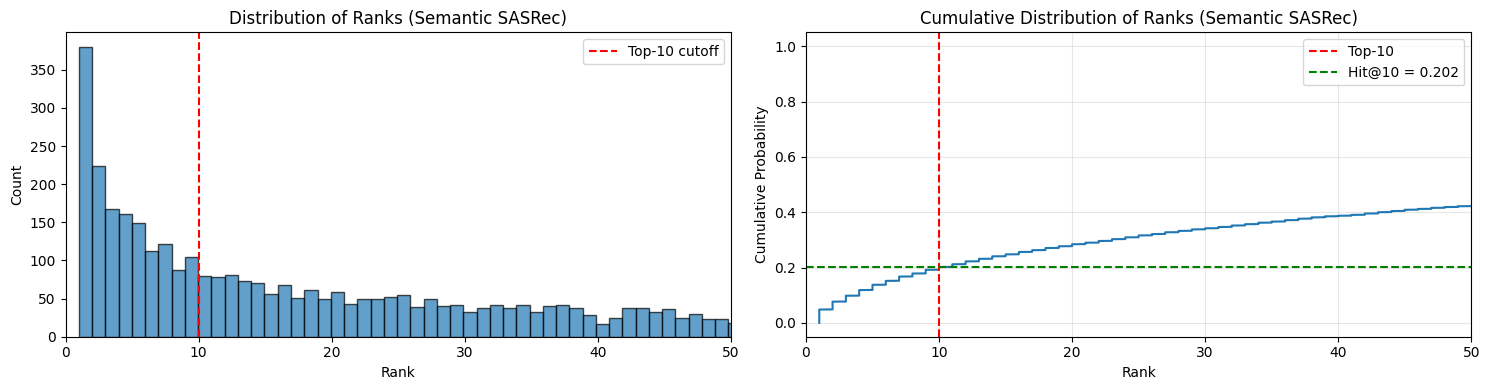

In [11]:
# Plot rank distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Histogram of ranks
axes[0].hist(ranks, bins=min(config.num_negative_samples, config.num_negative_samples), edgecolor="black", alpha=0.7)
axes[0].axvline(10, color="red", linestyle="--", label="Top-10 cutoff")
axes[0].set_xlabel("Rank")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Ranks (Semantic SASRec)")
axes[0].legend()
axes[0].set_xlim(0, 50)

# CDF of ranks
sorted_ranks = np.sort(ranks)
cdf = np.arange(1, len(sorted_ranks) + 1) / len(sorted_ranks)
axes[1].plot(sorted_ranks, cdf)
axes[1].axvline(10, color="red", linestyle="--", label="Top-10")
axes[1].axhline(metrics["hit@10"], color="green", linestyle="--", label=f"Hit@10 = {metrics['hit@10']:.3f}")
axes[1].set_xlabel("Rank")
axes[1].set_ylabel("Cumulative Probability")
axes[1].set_title("Cumulative Distribution of Ranks (Semantic SASRec)")
axes[1].legend()
axes[1].set_xlim(0, 50)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

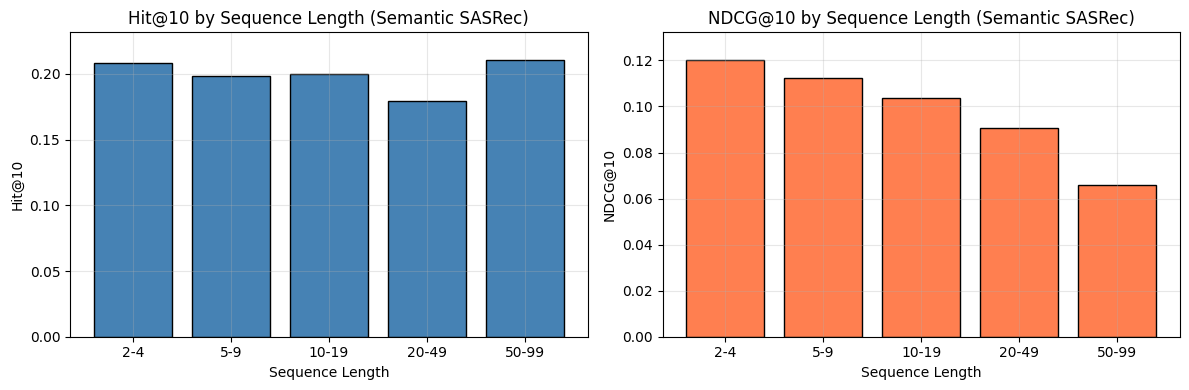

In [12]:
# Analyze performance by sequence length
seq_lengths = [seq_len for _, _, seq_len in val_data_tokens]
length_bins = [2, 5, 10, 20, 50, 100]
length_labels = ["2-4", "5-9", "10-19", "20-49", "50-99"]

# Bin sequences and calculate metrics per bin
binned_metrics = []
for i in range(len(length_bins) - 1):
    mask = (np.array(seq_lengths) >= length_bins[i]) & (np.array(seq_lengths) < length_bins[i + 1])
    if mask.sum() > 0:
        bin_ranks = ranks[mask]
        bin_metrics = calculate_metrics(bin_ranks, k=10)
        bin_metrics["count"] = mask.sum()
        binned_metrics.append(bin_metrics)
    else:
        binned_metrics.append({"hit@10": 0, "ndcg@10": 0, "count": 0})

# Plot metrics by sequence length
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Hit@10 by sequence length
hit_values = [m["hit@10"] for m in binned_metrics]
axes[0].bar(length_labels, hit_values, color="steelblue", edgecolor="black")
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Hit@10")
axes[0].set_title("Hit@10 by Sequence Length (Semantic SASRec)")
axes[0].set_ylim(0, max(hit_values) * 1.1 if max(hit_values) > 0 else 1)
axes[0].grid(True, alpha=0.3)

# NDCG@10 by sequence length
ndcg_values = [m["ndcg@10"] for m in binned_metrics]
axes[1].bar(length_labels, ndcg_values, color="coral", edgecolor="black")
axes[1].set_xlabel("Sequence Length")
axes[1].set_ylabel("NDCG@10")
axes[1].set_title("NDCG@10 by Sequence Length (Semantic SASRec)")
axes[1].set_ylim(0, max(ndcg_values) * 1.1 if max(ndcg_values) > 0 else 1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()